In [1]:
import os
from typing import Literal
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from einops import parse_shape, rearrange
from keras_core.losses import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras_core.callbacks import ModelCheckpoint, EarlyStopping
from keras_core.models import load_model

Using PyTorch backend.


In [3]:
def generate_data(csv_path,label,ratio=0.85,scaler="minmax",train_lookback=50,test_lookback=30):
    dataset = pd.read_csv(csv_path)
    dataset.set_index('datetime', inplace=True)
    label_index = dataset.columns.values.tolist().index(label)
    
    train, test = train_test_split(dataset,train_size=ratio,shuffle=False)
    # train.shape, test.shape
    
    train = train.values
    test = test.values
    
    train_X = []
    train_y = []

    for i in range(train_lookback, len(train)):
        train_X.append(train[i-train_lookback:i,:])
        train_y.append(train[i,label_index])
    train_X = np.array(train_X)
    train_y = np.expand_dims(np.array(train_y),axis=-1)

    test_X = []
    test_y = []

    for i in range(test_lookback, len(test)):
        test_X.append(test[i-test_lookback:i,:])
        test_y.append(test[i,label_index])
    test_X = np.array(test_X)
    test_y = np.expand_dims(np.array(test_y),axis=-1)
    # train_X.shape,train_y.shape,test_X.shape,test_y.shape
    
    if scaler == "zscore":
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
    elif scaler == "minmax":
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        
    x_shape=parse_shape(train_X,"N L C")
    train_X = X_scaler.fit_transform(rearrange(train_X, "N L C -> (N L) C"))
    train_X = rearrange(train_X, "(N L) C -> N L C", **x_shape)

    x_shape=parse_shape(test_X,"N L C")
    test_X = X_scaler.transform(rearrange(test_X, "N L C -> (N L) C"))
    test_X = rearrange(test_X, "(N L) C -> N L C", **x_shape)

    train_y = y_scaler.fit_transform(train_y)
    test_y = y_scaler.transform(test_y)

    # train_X.shape,train_y.shape,test_X.shape,test_y.shape
    
    return train_X, train_y, test_X, test_y, X_scaler, y_scaler

In [4]:
import keras_core as keras
from keras_core.layers import SimpleRNN,GRU,LSTM,Bidirectional,Dropout,Dense,InputLayer

def RNNModel(kind:Literal["rnn","gru","lstm"],shape,units=64,layers=2,bi=False,dropout=0.2):
    lst = [InputLayer(shape)]
    if layers > 1:
        if isinstance(units, list):
            assert len(units) == layers
        elif isinstance(units, int):
            units = [units] * layers
        for i in range(layers-1):
            j = units[i]
            if bi:
                if kind=="rnn":
                    lst.append(Bidirectional(SimpleRNN(j//2,return_sequences=True)))
                elif kind=="gru":
                    lst.append(Bidirectional(GRU(j//2,return_sequences=True)))
                elif kind=="lstm":
                    lst.append(Bidirectional(LSTM(j//2,return_sequences=True)))
            else:
                if kind=="rnn":
                    lst.append(SimpleRNN(j,return_sequences=True))
                elif kind=="gru":
                    lst.append(GRU(j,return_sequences=True))
                elif kind=="lstm":
                    lst.append(LSTM(j,return_sequences=True))
        if bi:
            if kind=="rnn":
                lst.append(Bidirectional(SimpleRNN(units[-1]//2)))
            elif kind=="gru":
                lst.append(Bidirectional(GRU(units[-1]//2)))
            elif kind=="lstm":
                lst.append(Bidirectional(LSTM(units[-1]//2)))
        else:
            if kind=="rnn":
                lst.append(SimpleRNN(units[-1]))
            elif kind=="gru":
                lst.append(GRU(units[-1]))
            elif kind=="lstm":
                lst.append(LSTM(units[-1]))
    else:
        if bi:
            if kind=="rnn":
                lst.append(Bidirectional(SimpleRNN(units//2)))
            elif kind=="gru":
                lst.append(Bidirectional(GRU(units//2)))
            elif kind=="lstm":
                lst.append(Bidirectional(LSTM(units//2)))
        else:
            if kind=="rnn":
                lst.append(SimpleRNN(units))
            elif kind=="gru":
                lst.append(GRU(units))
            elif kind=="lstm":
                lst.append(LSTM(units))
    lst.append(Dropout(dropout))
    lst.append(Dense(1))
    model = keras.Sequential(lst)
    return model

In [5]:
@keras.saving.register_keras_serializable(package="my_package", name="root_mean_squared_error")
def root_mean_squared_error(y_true, y_pred):
    return torch.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
label = "Adj_Close"
# label = "Residual"
ratio = 0.85
train_lookback=50
test_lookback=30
# scaler = "zscore"
scaler = "minmax"
csv_path = "data/aapl_qlib.csv"
# csv_path = "data/feat_eng_raw.csv"
# csv_path = "data/feat_eng_filtered.csv"

train_X, train_y, test_X, test_y, X_scaler, y_scaler = generate_data(csv_path, label)

rnn = RNNModel('lstm',train_X.shape[1:],units=[128,64,32],layers=3,bi=False,dropout=0.5)
rnn.compile(loss =root_mean_squared_error,optimizer = "adam")
# rnn.compile(loss ="mse",optimizer = "adam")
rnn.summary()

checkpoint = ModelCheckpoint("model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)

history = rnn.fit(train_X,train_y,validation_data=(test_X, test_y),batch_size=256,epochs=100, callbacks=[checkpoint,early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)           │     70,144 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)            │     49,408 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)                │     12,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 132,001 (515.63 KB)

 Trainable params: 132,001 (515.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1171
Epoch 1: val_loss improved from inf to 0.93747, saving model to model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.1152 - val_loss: 0.9375
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0439
Epoch 2: val_loss improved from 0.93747 to 0.89676, saving model to model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0437 - val_loss: 0.8968
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0421
Epoch 3: val_loss did not improve from 0.89676
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0420 - val_loss: 0.9806
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0378
Epoch 4: val_loss did not improve from 0.89676
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0378 - val_loss: 1.0098
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0460
Epoch 5: val_loss did not improve from 0.89676
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0460 - val_loss: 

In [7]:
best_model = load_model("model.keras")
prediction=best_model.predict(test_X)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


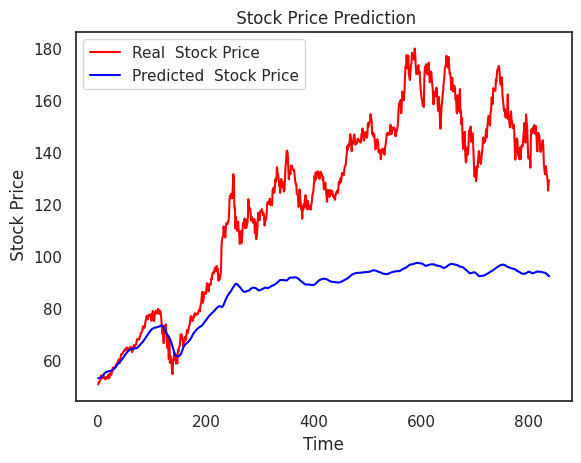

In [8]:
sns.set_theme(style="white")
plt.plot(y_scaler.inverse_transform(test_y), color = 'red', label = 'Real  Stock Price')
plt.plot(y_scaler.inverse_transform(prediction), color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()